In [71]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class MultiModalModel(nn.Module):
    def __init__(self, tabular_input_dim):
        super(MultiModalModel, self).__init__()
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        cnn_out_features = self.cnn.fc.in_features
        self.cnn.fc = nn.Identity()
        
        self.mlp = nn.Sequential(
            nn.Linear(tabular_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.fusion = nn.Sequential(
            nn.Linear(512 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, tabular):
        img_feats = self.cnn(image)
        tab_feats = self.mlp(tabular)
        combined = torch.cat((img_feats, tab_feats), dim=1)
        return self.fusion(combined)

In [72]:
from torch.utils.data import DataLoader
train_ds = MultimodalDataset("data/processed_train.csv", "house_images", transform=transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [73]:
class MultimodalDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{int(row['id'])}.jpg")
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        tabular = torch.tensor(row.drop(['id', 'price_log']).values, dtype=torch.float)
        target = torch.tensor(row['price_log'], dtype=torch.float).unsqueeze(0)
        
        return image, tabular, target

In [ ]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalModel(tabular_input_dim=17).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, total=len(train_loader), leave=True)
    loop.set_description(f"Epoch [{epoch+1}/{epochs}]")

    for images, tabular, targets in loop:
        images, tabular, targets = images.to(device), tabular.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images, tabular)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} complete. Average Loss: {avg_loss:.4f}")
torch.save(model.state_dict(), "data/multimodal_model.pth")
print("Model saved successfully!")

Epoch [1/20]: 100%|██████████| 402/402 [02:45<00:00,  2.43it/s, loss=0.18]  


Epoch 1 complete. Average Loss: 12.8402


Epoch [2/20]: 100%|██████████| 402/402 [01:26<00:00,  4.62it/s, loss=0.000141]


Epoch 2 complete. Average Loss: 0.1256


Epoch [3/20]: 100%|██████████| 402/402 [01:26<00:00,  4.64it/s, loss=0.124] 


Epoch 3 complete. Average Loss: 0.0772


Epoch [4/20]: 100%|██████████| 402/402 [01:32<00:00,  4.33it/s, loss=0.21]  


Epoch 4 complete. Average Loss: 0.0576


Epoch [5/20]: 100%|██████████| 402/402 [01:26<00:00,  4.65it/s, loss=0.0357]


Epoch 5 complete. Average Loss: 0.0473


Epoch [6/20]: 100%|██████████| 402/402 [01:28<00:00,  4.56it/s, loss=0.356] 


Epoch 6 complete. Average Loss: 0.0427


Epoch [7/20]: 100%|██████████| 402/402 [01:29<00:00,  4.48it/s, loss=0.673] 


Epoch 7 complete. Average Loss: 0.0413


Epoch [8/20]: 100%|██████████| 402/402 [01:30<00:00,  4.45it/s, loss=0.00281]


Epoch 8 complete. Average Loss: 0.0409


Epoch [9/20]: 100%|██████████| 402/402 [01:36<00:00,  4.15it/s, loss=0.0317]


Epoch 9 complete. Average Loss: 0.0329


Epoch [10/20]: 100%|██████████| 402/402 [01:30<00:00,  4.42it/s, loss=0.159] 


Epoch 10 complete. Average Loss: 0.0311


Epoch [11/20]: 100%|██████████| 402/402 [01:43<00:00,  3.89it/s, loss=0.046]  


Epoch 11 complete. Average Loss: 0.0307


Epoch [12/20]: 100%|██████████| 402/402 [01:49<00:00,  3.66it/s, loss=0.346]  


Epoch 12 complete. Average Loss: 0.0319


Epoch [13/20]: 100%|██████████| 402/402 [02:25<00:00,  2.77it/s, loss=0.364] 


Epoch 13 complete. Average Loss: 0.0332


Epoch [14/20]: 100%|██████████| 402/402 [01:32<00:00,  4.36it/s, loss=0.213] 


Epoch 14 complete. Average Loss: 0.0329


Epoch [15/20]: 100%|██████████| 402/402 [01:25<00:00,  4.68it/s, loss=0.282] 


Epoch 15 complete. Average Loss: 0.0294


Epoch [16/20]: 100%|██████████| 402/402 [01:25<00:00,  4.70it/s, loss=0.0432] 


Epoch 16 complete. Average Loss: 0.0279


Epoch [17/20]: 100%|██████████| 402/402 [01:32<00:00,  4.35it/s, loss=0.00114]


Epoch 17 complete. Average Loss: 0.0267


Epoch [18/20]: 100%|██████████| 402/402 [01:34<00:00,  4.26it/s, loss=0.0774]


Epoch 18 complete. Average Loss: 0.0247


Epoch [19/20]: 100%|██████████| 402/402 [02:00<00:00,  3.34it/s, loss=0.0389] 


Epoch 19 complete. Average Loss: 0.0274


Epoch [20/20]: 100%|██████████| 402/402 [01:29<00:00,  4.50it/s, loss=0.0717] 

Epoch 20 complete. Average Loss: 0.0255
Model saved successfully!


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

test_ds = MultimodalDataset("data/processed_test.csv", "house_images", transform)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, tabular, targets in tqdm(test_loader, desc="Evaluating"):
        images, tabular = images.to(device), tabular.to(device)
        
        outputs = model(images, tabular)
        
        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(targets.numpy())

real_preds = np.expm1(all_preds)
real_targets = np.expm1(all_targets)
rmse = np.sqrt(mean_squared_error(real_targets, real_preds))
r2 = r2_score(real_targets, real_preds)

print(f"\n--- Model Performance ---")
print(f"RMSE: ${rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

Evaluating: 100%|██████████| 101/101 [00:56<00:00,  1.79it/s]


--- Model Performance ---
RMSE: $166,183.80
R² Score: 0.7639


In [66]:
import pandas as pd
import numpy as np
import torch
import os
import joblib
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = joblib.load('data/scaler.pkl')

model = MultiModalModel(tabular_input_dim=17).to(device)
model.load_state_dict(torch.load("data/multimodal_model.pth"))
model.eval()

test2_df = pd.read_excel("test2.xlsx")
test2_df['house_age'] = 2025 - test2_df['yr_built']
test2_df['is_renovated'] = (test2_df['yr_renovated'] > 0).astype(int)
test2_df['sqft_lot_log'] = np.log1p(test2_df['sqft_lot'])

features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot_log', 'floors', 'waterfront', 
            'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 
            'sqft_lot15', 'lat', 'long', 'house_age', 'is_renovated']

X_test2_scaled = scaler.transform(test2_df[features])

class FinalInferenceDataset(Dataset):
    def __init__(self, df, scaled_features, img_dir, transform):
        self.df = df
        self.features = torch.tensor(scaled_features, dtype=torch.float)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = int(self.df.iloc[idx]['id'])
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        if os.path.exists(img_path):
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        else:
            image = torch.zeros((3, 224, 224))
            
        return image, self.features[idx], img_id


inference_ds = FinalInferenceDataset(test2_df, X_test2_scaled, "house_images", transform)
inference_loader = DataLoader(inference_ds, batch_size=32, shuffle=False)
all_ids, all_preds = [], []

with torch.no_grad():
    for imgs, tabs, house_ids in tqdm(inference_loader, desc="Predicting 5404 Houses"):
        imgs, tabs = imgs.to(device), tabs.to(device)
        outputs = model(imgs, tabs)
        real_prices = np.expm1(outputs.cpu().numpy())
        all_preds.extend(real_prices.flatten())
        all_ids.extend(house_ids.numpy())

submission = pd.DataFrame({'id': all_ids, 'predicted_price': all_preds})
submission.to_csv("CNN_prediction_prices.csv", index=False)

print(f"Successfully generated {len(submission)} predictions.")

Predicting 5404 Houses: 100%|██████████| 169/169 [00:11<00:00, 15.03it/s]

Successfully generated 5404 predictions.


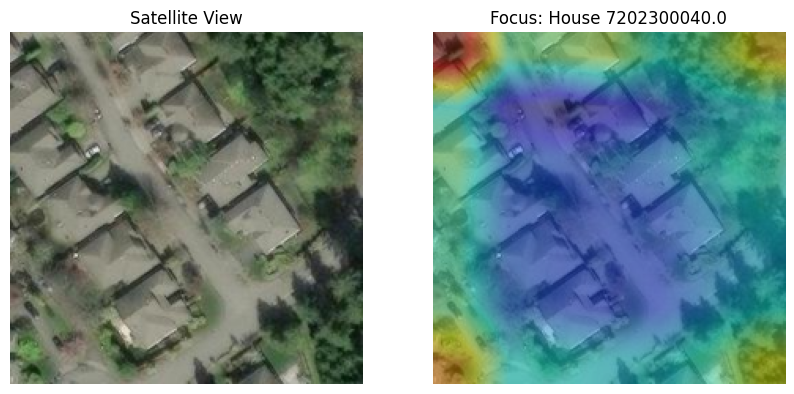

In [93]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_final_gradcam(model, house_id, dataset, device):
   
    idx = dataset.data[dataset.data['id'] == house_id].index[0]
    img_tensor, tab_tensor, _ = dataset[idx]
    
    target_layer = model.cnn.layer4[-1]
    
    activations = []
    gradients = []

    def save_activation(module, input, output): activations.append(output)
    def save_gradient(module, grad_input, grad_output): gradients.append(grad_output[0])

   
    h1 = target_layer.register_forward_hook(save_activation)
    h2 = target_layer.register_full_backward_hook(save_gradient)

    model.eval()
    img_in = img_tensor.unsqueeze(0).to(device)
    tab_in = tab_tensor.unsqueeze(0).to(device)
    
    output = model(img_in, tab_in)
    model.zero_grad()
    output.backward()

    grads = gradients[0].cpu().data.numpy().squeeze()
    fmap = activations[0].cpu().data.numpy().squeeze()
    weights = np.mean(grads, axis=(1, 2))
    
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)

    img_display = img_tensor.permute(1, 2, 0).cpu().numpy()

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = (std * img_display + mean)
    img_display = np.clip(img_display, 0, 1)

    heatmap_color = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    img_display = img_display.astype(np.float32)
    
    overlay = cv2.addWeighted(img_display, 0.6, heatmap_color, 0.4, 0)

    h1.remove()
    h2.remove()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_display)
    plt.title("Satellite View")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Focus: House {house_id}")
    plt.axis('off')
    plt.show()

sample_id = train_ds.data.iloc[0]['id']
generate_final_gradcam(model, sample_id, train_ds, device)